<a href="https://colab.research.google.com/github/byeoli/BasicProgrammings/blob/master/AI501_Assignment4_20203640.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Read Data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
filename = '/content/drive/MyDrive/input.txt'

In [44]:
# imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import scipy.linalg as la
import matplotlib.cm as cm
from matplotlib import rc
import time
from IPython import display

%matplotlib inline

np.random.seed(42)

In [45]:
data = pd.read_csv(filename)
data.head()

data = np.loadtxt(filename, delimiter=" ").T

print(data.shape)
print(data)

(2, 2000)
[[-4.91971475 -1.31715522 -1.31774129 ... -0.93692817 -0.95434744
  -0.22386843]
 [-4.74608097  4.03074753  4.40452393 ...  1.54740857  1.56950832
  -1.20293544]]


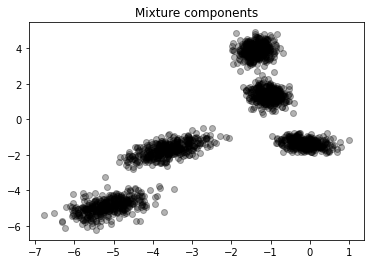

In [46]:
# Visualize the data

X, Y = np.meshgrid(np.linspace(-10,10,100), np.linspace(-10,10,100))
pos = np.dstack((X, Y))

# plot the dataset
plt.figure()
plt.title("Mixture components")
plt.plot(data[0, :], data[1, :], 'ko', alpha=0.3)


In [53]:
# Initialize the parameters

K = 5

means = np.zeros((K,2))
covs = np.zeros((K,2,2))
for k in range(K):
    means[k] = np.random.normal(size=(2,))
    covs[k] = np.eye(2)

weights = np.ones((K,1))/K

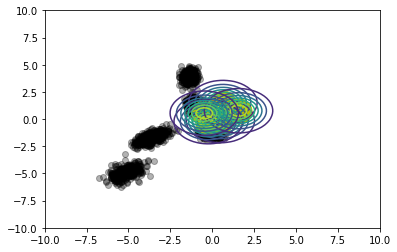

In [48]:
NLL = [] # log-likelihood of the MOG
mog_nll = 0
for k in range(K):
    mog_nll += weights[k]*multivariate_normal.pdf(mean=means[k,:], cov=covs[k,:,:], x=data.T)
NLL += [-np.sum(np.log(mog_nll))]

plt.figure()
plt.plot(data[0, :], data[1, :], 'ko', alpha=0.3)
plt.plot(means[:,0], means[:,1], 'oy', markersize=25)

for k in range(K):
    rv = multivariate_normal(means[k,:], covs[k,:,:])
    plt.contour(X, Y, rv.pdf(pos), alpha = 1.0, zorder=10)

### EM Algorithm

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

Converged after iteration  22


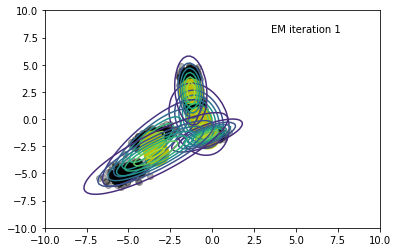

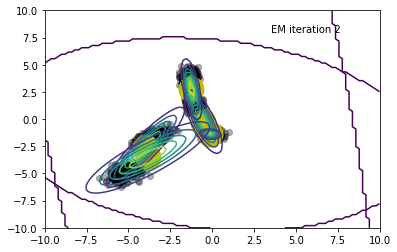

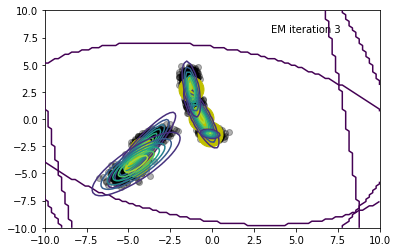

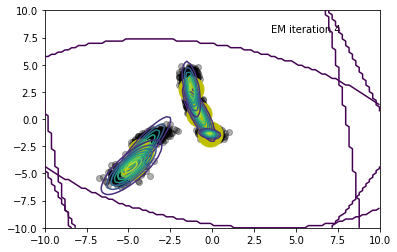

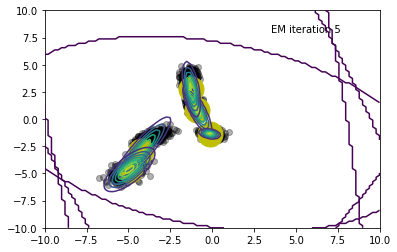

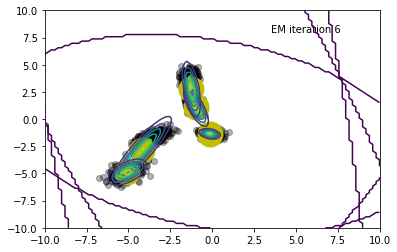

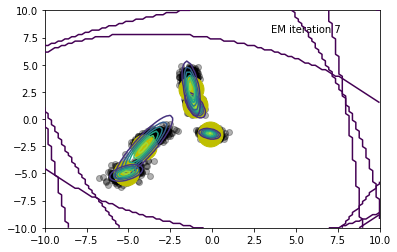

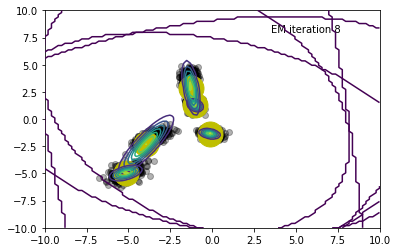

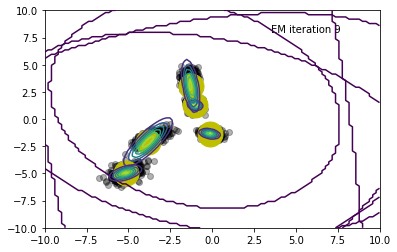

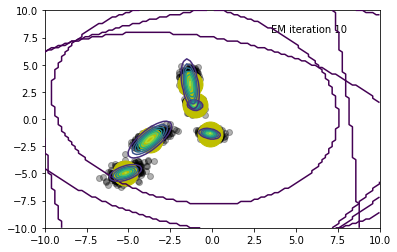

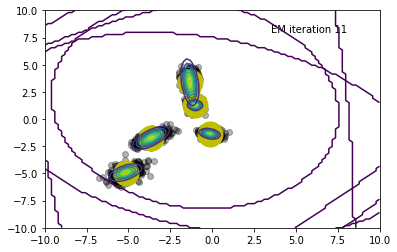

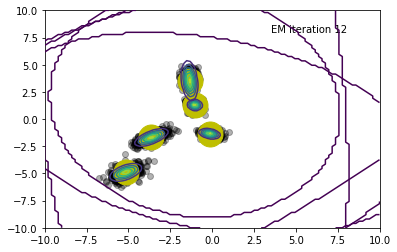

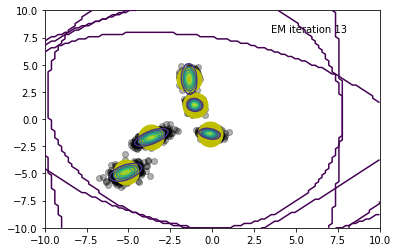

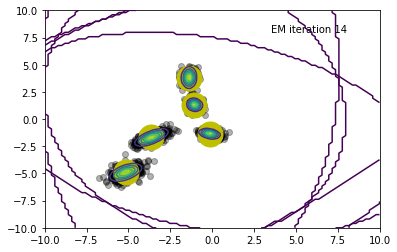

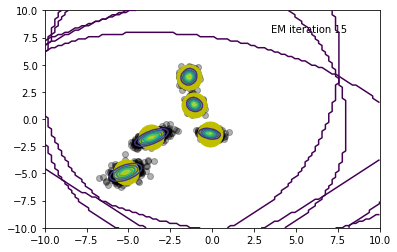

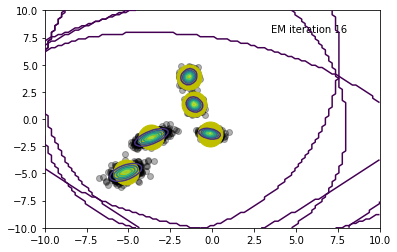

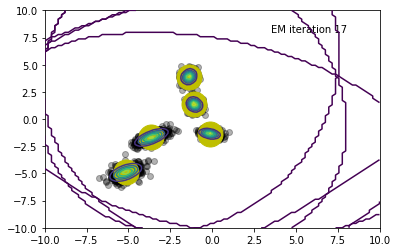

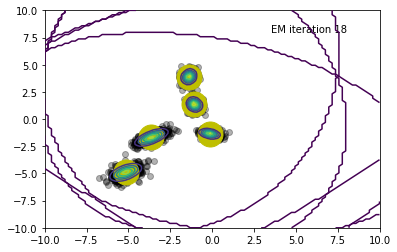

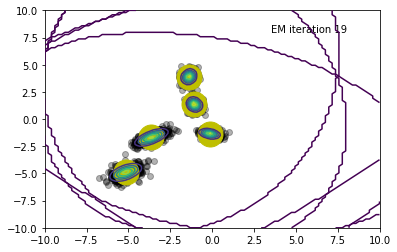

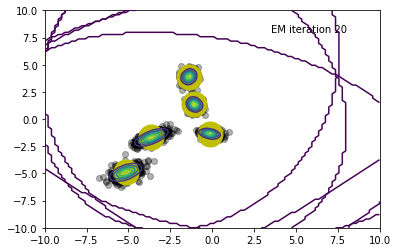

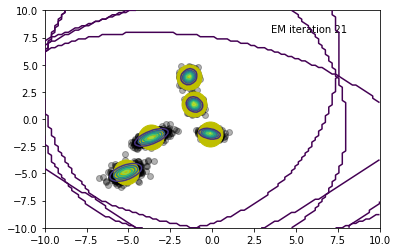

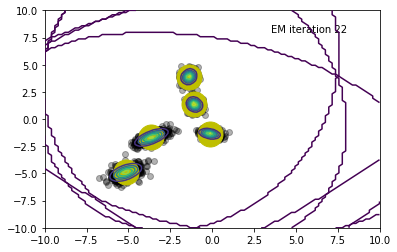

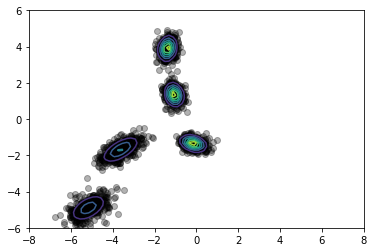

In [54]:
N = 2000
K = 5
r = np.zeros((K,N))

for em_iter in range(100):    
    means_old = means.copy()
    
    # E-step: update responsibilities
    for k in range(K):
        r[k] = weights[k]*multivariate_normal.pdf(mean=means[k,:], cov=covs[k,:,:], x=data.T)  
        
    r = r/np.sum(r, axis=0) 
        
    # M-step
    N_k = np.sum(r, axis=1)

    for k in range(K): 
        # update means
        means[k] = np.sum(r[k]*data, axis=1)/N_k[k]
        
        # update covariances
        diff = data - means[k:k+1].T
        _tmp = np.sqrt(r[k:k+1])*diff
        covs[k] = np.inner(_tmp, _tmp)/N_k[k]
        
    # weights
    weights = N_k/N 
    
    # log-likelihood
    mog_nll = 0
    for k in range(K):
      mog_nll += weights[k]*multivariate_normal.pdf(mean=means[k,:].ravel(), cov=covs[k,:,:], x=data.T)
    NLL += [-np.sum(np.log(mog_nll))]
    # for k in range(5):
    #   mog_nll += r[k]*(np.log(weights[k])+multivariate_normal.logpdf(mean=means[k,:].ravel(), cov=covs[k,:,:], x=data.T))
    # NLL += [-np.sum(mog_nll)]
    
    plt.figure() 
    plt.plot(data[0, :], data[1, :], 'ko', alpha=0.3)
    plt.plot(means[:,0], means[:,1], 'oy', markersize=25)
    for k in range(K):
        rv = multivariate_normal(means[k,:], covs[k])
        plt.contour(X, Y, rv.pdf(pos), alpha = 1.0, zorder=10)
        
    plt.text(x=3.5, y=8, s="EM iteration "+str(em_iter+1))
    
    if la.norm(NLL[em_iter+1]-NLL[em_iter]) < 1e-6:
        print("Converged after iteration ", em_iter+1)
        break
   
# plot final the mixture model
plt.figure() 
mog = 0
for k in range(5):
    mix_comp = multivariate_normal(means[k,:].ravel(), covs[k,:,:])
    mog += weights[k]*mix_comp.pdf(pos)

plt.plot(data[0, :], data[1, :], 'ko', alpha=0.3)
plt.contour(X, Y, mog,  alpha = 1.0, zorder=10)    
plt.xlim([-8,8]);
plt.ylim([-6,6]);

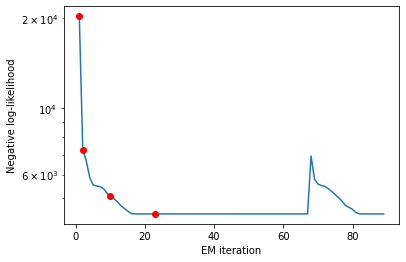

In [55]:
plt.figure()
plt.semilogy(np.linspace(1,len(NLL), len(NLL)), NLL)
plt.xlabel("EM iteration");
plt.ylabel("Negative log-likelihood");

idx = [0, 1, 9, em_iter+1]

for i in idx:
    plt.plot(i+1, NLL[i], 'or')